In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import pickle
from multiprocessing import Pool
from tqdm import tqdm

# Prepare data

* Attributed rate: how attribution is distributed in combinations
* Click counts: how clicks are distributed in combinations
* Rolling click counts: how clicks are distributed in combinations in sliding windows

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
res_hdf_path = '../derived_data/feats_pile.hdf'

In [4]:
%%time
dat = pd.read_hdf(hdf_path, key='train')

CPU times: user 221 ms, sys: 1.89 s, total: 2.11 s
Wall time: 2.13 s


In [5]:
dat.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [6]:
train = dat.loc[(dat.click_time >= '2017-11-08 04:00:00') & (dat.click_time < '2017-11-08 15:00:00')].copy()

In [7]:
valid = dat.loc[(dat.click_time >= '2017-11-09 04:00:00') & (dat.click_time < '2017-11-09 15:00:00')].copy()

In [8]:
del dat

In [9]:
gc.collect()

24

In [10]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [11]:
feats2comb = ['ip', 'app', 'device', 'os', 'channel']

In [12]:
def get_all_comb_feats(feats2comb, n=None):
    if n is None:
        n = len(feats2comb)
    res = []
    for i in range(n):
        for comb_feats in combinations(feats2comb, i+1):
            res.append(list(comb_feats))
    return res

In [13]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
def choose_int_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'

In [ ]:
def get_next_click(args):
    df = args[0]
    df.loc[:, 'epochtime'] = df.click_time.astype(np.int64) / 1e9
    click_cols = args[1]
    gp = gp.groupby(click_cols)
    df.loc[:, 'order_left'] = gp.cumcount()
    df.loc[:, 'order_next'] = df.order_left - 1
    left_selcols = click_cols + ['order_left', 'epochtime']
    right_selcols = click_cols + ['order_next', 'epochtime']
    next_df = pd.merge(df.loc[:, left_selcols], df.loc[:, right_selcols],
                        left_on=click_cols+['order_left'], right_on=click_cols+['order_next'],
                        how='left', suffixes=('', '_next'))
    next_click_col = 'nextclick_{}'.join(click_cols)
    next_df.loc[:, next_click_col] = next_df.epochtime_next - next_df.epochtime
    next_df = next_df.fillna(-1).loc[:, [next_click_col]]

    df.loc[:, 'order_next'] = df.order_left - 2
    nextnext_df = pd.merge(df.loc[:, left_selcols], df.loc[:, right_selcols],
                        left_on=click_cols+['order_left'], right_on=click_cols+['order_next'],
                        how='left', suffixes=('', '_next'))
    nextnext_click_col = 'nextnextclick_{}'.join(click_cols)
    nextnext_df.loc[:, nextnext_click_col] = nextnext_df.epochtime_next - nextnext_df.epochtime
    nextnext_df = nextnext_df.fillna(-1).loc[:, [nextnext_click_col]]
    res = pd.concat([next_df, nextnext_df])
    gc.collect()
    return res

In [14]:
def get_label_count(args):
    gp = args[0].groupby(args[1], sort=False).size()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_count'})
    gc.collect()
    return gp

In [15]:
def get_label_cumcount(args):
    gp = args[0].groupby(args[1], sort=False).cumcount()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_cumcount'})
    gc.collect()
    return gp

In [16]:
time_win = '15min'

In [17]:
def rolling_sum(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).sum()

def get_label_rolling_sum(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_sum)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_sum'})
    gc.collect()
    return gp

In [18]:
def rolling_count(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).count()

def get_label_rolling_count(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_count)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_count'})
    gc.collect()
    return gp

In [19]:
def rolling_max(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).max()

def get_label_rolling_max(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_max)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_max'})
    gc.collect()
    return gp

In [20]:
def rolling_min(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).min()

def get_label_rolling_min(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_min)
    gp = gp.astype(choose_int_type(gp.min()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_min'})
    gc.collect()
    return gp

In [21]:
def rolling_mean(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).mean()

def get_label_rolling_mean(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_mean)
    gp = gp.astype('float16')
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_mean'})
    gc.collect()
    return gp

In [22]:
def rolling_std(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).std()

def get_label_rolling_std(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_std)
    gp = gp.fillna(-1)
    gp = gp.astype('float16')
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_std'})
    gc.collect()
    return gp

In [23]:
def get_nunique(array):
    return len(np.unique(array))

def get_label_rolling_nunique(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'nunique_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_nunique)

In [24]:
def get_entropy(array):
    values, counts = np.unique(array, return_counts=True)
    prob = counts / len(array)
    return - (prob * np.log(prob)).sum()

def get_label_rolling_entropy(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'entropy_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_entropy)

In [25]:
def get_frequency(array):
    return (array == array[-1]).sum()

def get_label_rolling_frequency(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'freq_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_frequency)

In [26]:
def get_probability(array):
    values, counts = np.unique(array, return_counts=True)
    prob = counts / len(array)
    return prob[values == array[-1]]

def get_label_rolling_frequency(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'freq_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_probability)

In [27]:
def get_labels(function, all_comb_feats):
    print(pd.datetime.now())
    aggs = []
    with Pool(processes=8) as pool:
        for dist in pool.imap_unordered(function, all_comb_feats):
            aggs.append(dist.copy())
            gc.collect()
    return aggs

In [28]:
def merge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_on=dist.index.names, right_index=True, how='left')
    return df

In [29]:
def cummerge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_index=True, right_index=True, how='left')
    return df

In [30]:
all_comb_feats = get_all_comb_feats(feats2comb, 1)

In [31]:
len(all_comb_feats)

5

In [32]:
train_all_comb_feats =[(train, comb_feat) for comb_feat in all_comb_feats]
                  # [['hour'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['minute'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['day_section'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['in_test_hh', 'day_section'] + comb_feat for comb_feat in all_comb_feats])

In [33]:
valid_all_comb_feats =[(valid, comb_feat) for comb_feat in all_comb_feats]

In [34]:
def process(df, all_comb_feats, to_get):
    print('Adding hour...')
    df.loc[:, 'hour'] = df.click_time.dt.hour.astype('uint8')
    print('Adding minute...')
    df.loc[:, 'minute'] = df.hour.astype('uint16') * 60 + df.click_time.dt.minute.astype('uint16')
    print('Adding in_test_hh')
    df.loc[:, 'in_test_hh'] = (
        3 - 2*df.hour.isin(most_freq_hours_in_test_data) -
        1*df.hour.isin(least_freq_hours_in_test_data)
    ).astype('uint8')
    print('Adding day_section...')
    df.loc[:, 'day_section'] = (df.hour // 6).astype('uint8')
    df_counts = []
    if isinstance(to_get, str):
        to_get = [to_get]
    cumset = {'cumcount', 'rolling_nunique', 'rolling_entropy', 'rolling_frequency', 'rolling_probability'}
    if len(cumset & set(to_get)) > 0:
        if 'cumcount' in to_get:
            print('Getting cummulative counts...')
            df_counts += get_labels(get_label_cumcount, all_comb_feats)
        if 'rolling_nunique' in to_get:
            print('Getting rolling  nunique...')
            df_counts += get_labels(get_label_rolling_nunique, all_comb_feats)
        if 'rolling_entropy' in to_get:
            print('Getting rolling entropy...')
            df_counts += get_labels(get_label_rolling_entropy, all_comb_feats)
        if 'rolling_' in to_get:
            print('Getting rolling frequency...')
            df_counts += get_labels(get_label_rolling_frequency, all_comb_feats)
        if 'rolling_' in to_get:
            print('Getting rolling probability...')
            df_counts += get_labels(get_label_rolling_probability, all_comb_feats)
        print('Concat...')
        df = cummerge(df, df_counts)
    else:
        if 'count' in to_get:
            print('Getting count...')
            df_counts += get_labels(get_label_count, all_comb_feats)
        if 'rolling_count'  in to_get:
            print('Getting rolling count...')
            df_counts += get_labels(get_label_rolling_count, all_comb_feats)
        if 'rolling_sum' in to_get:
            print('Getting rolling sum...')
            df_counts += get_labels(get_label_rolling_sum, all_comb_feats)
        if 'rolling_max' in to_get:
            print('Getting rolling max...')
            df_counts += get_labels(get_label_rolling_max, all_comb_feats)
        if 'rolling_min' in to_get:
            print('Getting rolling min...')
            df_counts += get_labels(get_label_rolling_min, all_comb_feats)
        if 'rolling_mean' in to_get:
            print('Getting rolling mean...')
            df_counts += get_labels(get_label_rolling_mean, all_comb_feats)
        if 'rolling_std' in to_get:
            print('Getting rolling std...')
            df_counts += get_labels(get_label_rolling_std, all_comb_feats)
        print('Merging...')
        df = merge(df, df_counts)
    
    gc.collect()
    return df

In [35]:
to_get = ['rolling_nunique']

In [36]:
%%time
train = process(train, train_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting rolling  nunique...
2018-04-21 09:49:41.624693


KeyboardInterrupt: 

In [33]:
%%time
valid = process(valid, valid_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting rolling count...
2018-04-20 18:48:25.748983
Getting rolling sum...
2018-04-20 18:49:46.827228
Getting rolling max...
2018-04-20 18:51:09.084470
Getting rolling min...
2018-04-20 18:52:35.492762
Getting rolling mean...
2018-04-20 18:54:02.719303
Getting rolling std...
2018-04-20 18:55:24.311762


  0%|          | 0/30 [00:00<?, ?it/s]

Merging...


100%|██████████| 30/30 [02:36<00:00,  5.21s/it]

CPU times: user 2min 49s, sys: 1min 50s, total: 4min 39s
Wall time: 11min 4s


In [36]:
%%time
train.to_hdf(res_hdf_path, key=to_get+'_train', model='r+')

CPU times: user 1.65 s, sys: 1.62 s, total: 3.27 s
Wall time: 3.28 s


In [37]:
%%time
valid.to_hdf(res_hdf_path, key=to_get+'_valid', model='r+')

CPU times: user 1.76 s, sys: 1.61 s, total: 3.36 s
Wall time: 3.55 s


In [38]:
gc.collect()

0

In [10]:
train = pd.read_hdf(res_hdf_path, key=to_get+'_train')

In [11]:
valid = pd.read_hdf(res_hdf_path, key=to_get+'_valid')

# Split for training

In [34]:
gc.collect()

0

In [35]:
train.drop(['ip', 'click_time'], axis=1, inplace=True)

In [36]:
valid.drop(['ip', 'click_time'], axis=1, inplace=True)

In [37]:
gc.collect()

14

In [38]:
_, valid = train_test_split(valid, test_size=0.2, stratify=valid.is_attributed)

In [39]:
train.shape

(36475438, 39)

In [40]:
train.is_attributed.value_counts(normalize=True)

0    0.997421
1    0.002579
Name: is_attributed, dtype: float64

In [41]:
valid.shape

(7433836, 39)

In [42]:
valid.is_attributed.value_counts(normalize=True)

0    0.997415
1    0.002585
Name: is_attributed, dtype: float64

# Light GBM

In [43]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'hour', 'minute',
       'in_test_hh', 'day_section', 'app_rolling_count',
       'device_rolling_count', 'os_rolling_count', 'channel_rolling_count',
       'ip_rolling_count', 'app_rolling_sum', 'device_rolling_sum',
       'os_rolling_sum', 'channel_rolling_sum', 'ip_rolling_sum',
       'app_rolling_max', 'device_rolling_max', 'os_rolling_max',
       'channel_rolling_max', 'ip_rolling_max', 'app_rolling_min',
       'device_rolling_min', 'os_rolling_min', 'channel_rolling_min',
       'ip_rolling_min', 'app_rolling_mean', 'device_rolling_mean',
       'os_rolling_mean', 'channel_rolling_mean', 'ip_rolling_mean',
       'app_rolling_std', 'device_rolling_std', 'os_rolling_std',
       'channel_rolling_std', 'ip_rolling_std'],
      dtype='object')

In [44]:
target = 'is_attributed'

In [45]:
predictors = train.columns.tolist()

In [46]:
predictors.remove(target)

In [47]:
predictors

['app',
 'device',
 'os',
 'channel',
 'hour',
 'minute',
 'in_test_hh',
 'day_section',
 'app_rolling_count',
 'device_rolling_count',
 'os_rolling_count',
 'channel_rolling_count',
 'ip_rolling_count',
 'app_rolling_sum',
 'device_rolling_sum',
 'os_rolling_sum',
 'channel_rolling_sum',
 'ip_rolling_sum',
 'app_rolling_max',
 'device_rolling_max',
 'os_rolling_max',
 'channel_rolling_max',
 'ip_rolling_max',
 'app_rolling_min',
 'device_rolling_min',
 'os_rolling_min',
 'channel_rolling_min',
 'ip_rolling_min',
 'app_rolling_mean',
 'device_rolling_mean',
 'os_rolling_mean',
 'channel_rolling_mean',
 'ip_rolling_mean',
 'app_rolling_std',
 'device_rolling_std',
 'os_rolling_std',
 'channel_rolling_std',
 'ip_rolling_std']

In [48]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'in_test_hh', 'day_section']

In [49]:
gc.collect()

21

In [50]:
params = {
    'boosting_type': 'dart',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 10,  # Was 255: Reduced to control overfitting Try increasing this
    'max_depth': -1,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 10, # try increasing this
    'max_bin': 100, # try increasing this
    'subsample': 0.7,  # Was 0.7 # try decreasing this
    'subsample_freq': 1, # try 0
    'colsample_bytree': 0.7, # try decreasing
    'min_child_weight': 0, # try increasing
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 200
}

In [51]:
dtrain = lgb.Dataset(
    train.loc[:, predictors],
    label=train.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid.loc[:, predictors],
    label=valid.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

In [52]:
del train

In [53]:
del valid

In [54]:
gc.collect()

44

In [55]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None
)

/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.963458	valid's auc: 0.951099
[20]	train's auc: 0.968081	valid's auc: 0.955915
[30]	train's auc: 0.970732	valid's auc: 0.95902
[40]	train's auc: 0.971697	valid's auc: 0.95977
[50]	train's auc: 0.972227	valid's auc: 0.960364
[60]	train's auc: 0.972686	valid's auc: 0.960618
[70]	train's auc: 0.972955	valid's auc: 0.960981
[80]	train's auc: 0.97332	valid's auc: 0.961283
[90]	train's auc: 0.973475	valid's auc: 0.961212
[100]	train's auc: 0.973608	valid's auc: 0.961404
[110]	train's auc: 0.973683	valid's auc: 0.96145
[120]	train's auc: 0.973917	valid's auc: 0.961677
[130]	train's auc: 0.974328	valid's auc: 0.961734
[140]	train's auc: 0.974595	valid's auc: 0.961971
[150]	train's auc: 0.974678	valid's auc: 0.962133
[160]	train's auc: 0.974692	valid's auc: 0.962168
[170]	train's auc: 0.975011	valid's auc: 0.962317
[180]	train's auc: 0.975285	valid's auc: 0.962242
[190]	train's auc: 0.975749	valid's auc: 0.962611
[

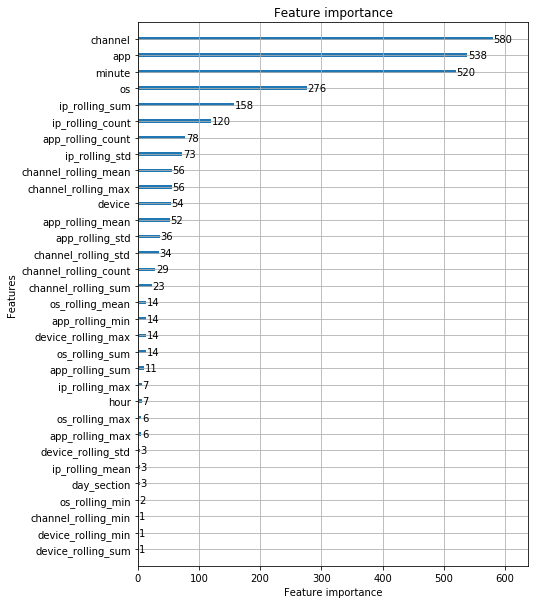

In [56]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [57]:
import pickle

In [58]:
with open('../results/{}.pickle'.format(to_get), 'wb') as f:
    pickle.dump(lgb_model, f)

# Create submission

In [59]:
test = pd.read_hdf(hdf_path, key='test')

In [60]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [61]:
test_all_comb_feats =[(test, comb_feat) for comb_feat in all_comb_feats]

In [62]:
test = process(test, test_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting rolling count...
2018-04-20 20:08:36.974720
Getting rolling sum...
2018-04-20 20:09:47.881770
Getting rolling max...
2018-04-20 20:10:59.674602
Getting rolling min...
2018-04-20 20:12:11.095330
Getting rolling mean...
2018-04-20 20:13:22.121227
Getting rolling std...
2018-04-20 20:14:31.027235


  0%|          | 0/30 [00:00<?, ?it/s]

Merging...


100%|██████████| 30/30 [01:16<00:00,  2.56s/it]


In [63]:
test.head()

,click_id,ip,app,device,os,channel,click_time,hour,minute,in_test_hh,...,app_rolling_mean,device_rolling_mean,os_rolling_mean,channel_rolling_mean,ip_rolling_mean,app_rolling_std,device_rolling_std,os_rolling_std,channel_rolling_std,ip_rolling_std
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,240,1,...,49.0,408.0,4.0,31.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,240,1,...,49.0,408.0,4.0,7.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,240,1,...,10.0,408.0,102.0,6.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,240,1,...,30.0,408.0,76.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,240,1,...,40.0,408.0,76.0,3.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [64]:
pred = lgb_model.predict(test.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [65]:
test.loc[:, 'is_attributed'] = pred

In [66]:
test.loc[:, ['click_id', 'is_attributed']].to_csv('../results/{}.csv'.format('_'.join(to_get)), index=False)

In [67]:
test.loc[:, ['click_id', 'is_attributed']].head()

,click_id,is_attributed
0,0,0.267598
1,1,0.407673
2,2,0.307372
3,3,0.425557
4,4,0.296750
